# Competitive Hebbian Learning through Spike-Timing-Dependent Synaptic Plasticity

This notebook contains an implementation of the model presented in the paper:

**Song, S., Miller, K. D., & Abbott, L. F. (2000). "Competitive Hebbian learning through spike-timing-dependent synaptic plasticity." Nature Neuroscience, 3(9), 919–926.**  
[Link to the paper](https://www.nature.com/articles/nn0900_919)

- The `generate_input` function uses code adapted from the [Neuro4ML](https://github.com/neuro4ml/neuro4ml.github.io/blob/main/materials/w4/w4-figures.ipynb) course to produce input stimuli. While this implementation slightly differs from the method described in the paper, it does not affect the final results of the experiment.

- The main difference from the original paper is the parameter `g_max_ex`. In the paper, this value is set to 0.015. However, in my experiments, the excitatory synapses were not strong enough to raise the postsynaptic neuron's membrane potential to the threshold required for spiking. As a result, the network failed to learn. By adjusting `g_max_ex` to 0.04, the network successfully achieves the same learning outcomes as reported in the paper.

- Additional experiments have been conducted to explore the effects of varying hyperparameters.

- I aimed to use the same notation as the original paper to ensure clarity and ease of understanding.

In [1]:
from brian2 import *
prefs.codegen.target = "numpy"
import numpy as np
import copy
from src.input import generate_input
from src.model import run_experiment
from src.plot import plot_experiment

In [2]:
N= 1200
excitatory_ratio = 5/6
groupsize= 100 
num_repeat = 90
episode_duration = 70*ms

In [3]:
pre_synapse, first_spike_time, input_stimuli_monitor = generate_input(N, groupsize, num_repeat, episode_duration)

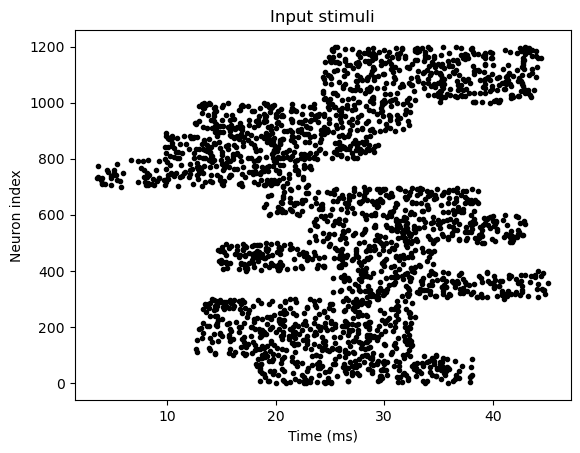

In [4]:
plt.plot(input_stimuli_monitor.t/ms, input_stimuli_monitor.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Input stimuli')
plt.show()

In [4]:
tau_m = 20*ms
V_rest = -70*mV
E_ex = 0*mV
E_in = -70*mV
V_threshold = -54*mV
V_reset = -60*mV

tau_ex = 5*ms
##  0<= g_a <= g_max_ex
g_max_ex = 0.04
tau_in = 5*ms
g_max_in = 0.05

A_pre = 0.005
tau_pre = 20*ms
tau_post =  20*ms
B = 1.05
A_post = -A_pre*tau_pre*B/tau_post

params = {'N' : N,
        'excitatory_ratio' : excitatory_ratio,
        'tau_m': tau_m,
        'V_rest': V_rest,
        'E_ex' : E_ex,
        'E_in' : E_in,
        'tau_ex' : tau_ex,
        'g_max_ex' : g_max_ex,
        'tau_in' : tau_in,
        'g_max_in' : g_max_in,
        'A_pre' : A_pre,
        'tau_pre' : tau_pre,
        'tau_post' : tau_post,
        'A_post' : A_post,
        'V_threshold': V_threshold,
        'V_reset': V_reset}

In [5]:
pre_synapse_temp = copy.copy(pre_synapse)
(pre_spike_mon, post_spike_mon), S, post_state_mon, excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)

In [7]:
plot_params = {
    'g_max_ex': g_max_ex,
    'g_max_in': g_max_in,
    'A_pre': A_pre,
    'A_post': A_post,
    'episode_duration': episode_duration,
    'num_repeat': num_repeat,
    'tau_pre': tau_pre,
    'tau_post': tau_post,
    'B': B,
    'post_spike_mon': post_spike_mon,
    'post_state_mon': post_state_mon,
    'input_stimuli_monitor': input_stimuli_monitor,
    'first_spike_time': first_spike_time,
    'S': S,
    'excitatory_idx': excitatory_idx
}

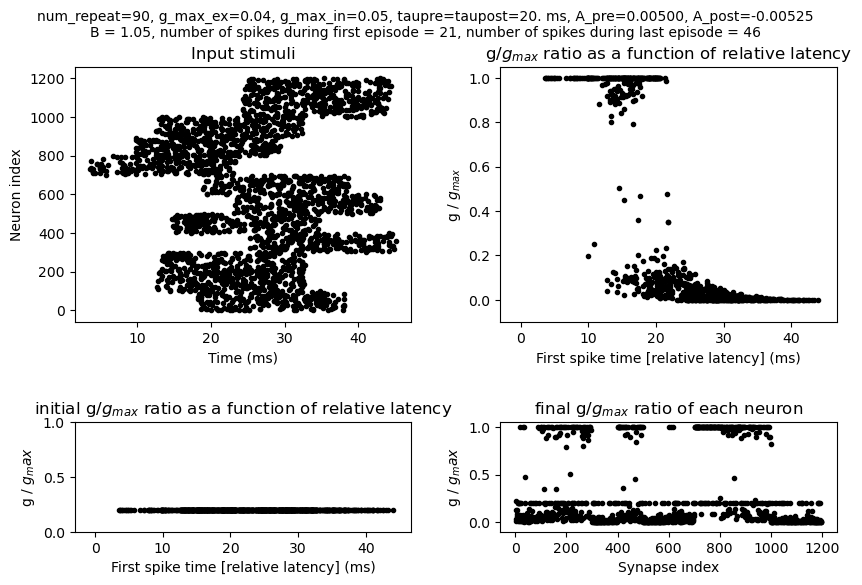

In [8]:
plot_experiment(file_name=None, display=True, params= plot_params)

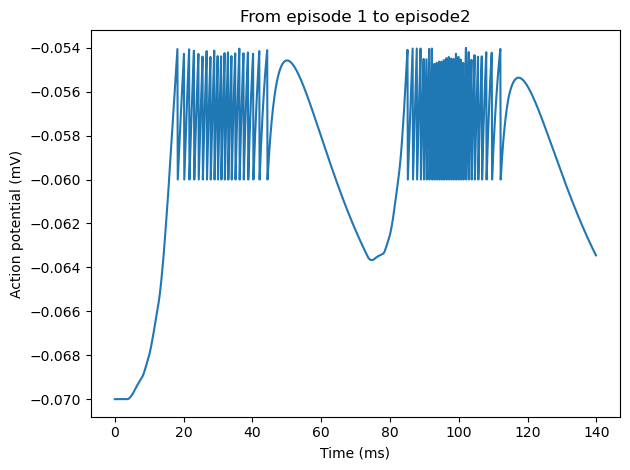

In [9]:
episode_span = int(episode_duration/ms*10)
first_episode_num = 0 
last_episode_num = 2

last_episode_duration = post_state_mon.t[first_episode_num*episode_span:last_episode_num*episode_span]/ms
last_episode_start_time = post_state_mon.t[first_episode_num*episode_span]/ms
last_episode_v = post_state_mon.V[0][first_episode_num*episode_span:last_episode_num*episode_span]

plt.plot(last_episode_duration , last_episode_v) # - last_episode_start_time
plt.xlabel('Time (ms)')
plt.ylabel('Action potential (mV)')
plt.title(f'From episode {first_episode_num+1} to episode{last_episode_num}')
plt.tight_layout()
plt.show()

number of spikes during first episode = 21, number of spikes during last episode = 46


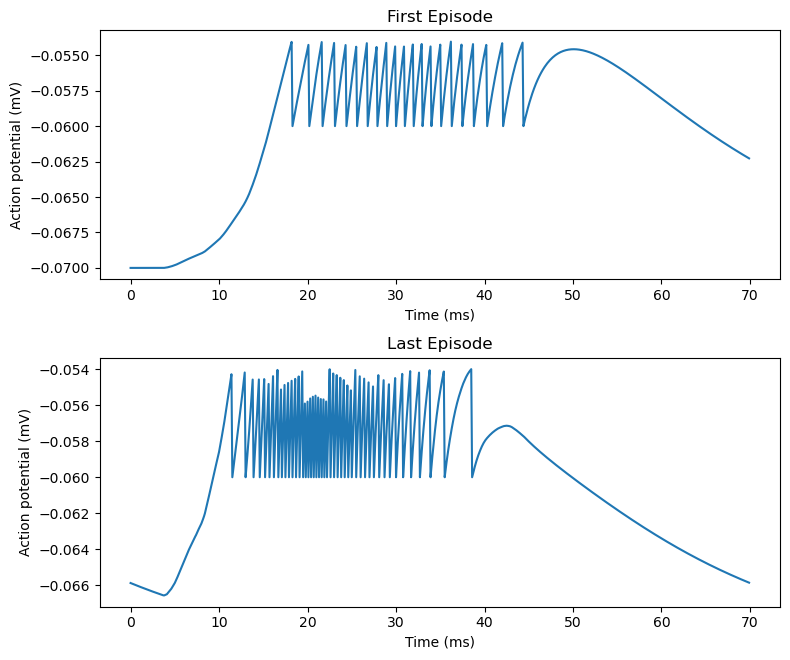

In [10]:
episode_span = int(episode_duration/ms*10) #700
num_episodes = 1

first_episode_duration = post_state_mon.t[:num_episodes*episode_span]/ms
first_episode_v = post_state_mon.V[0][:num_episodes*episode_span]
last_episode_duration = post_state_mon.t[-num_episodes*episode_span:]/ms
last_episode_start_time = post_state_mon.t[-num_episodes*episode_span]/ms
last_episode_v = post_state_mon.V[0][-num_episodes*episode_span:]

num_spikes_last_episode = len(post_spike_mon.t[post_spike_mon.t/ms > post_state_mon.t[-num_episodes*episode_span]/ms])
num_spikes_first_episode = len(post_spike_mon.t[post_spike_mon.t/ms < post_state_mon.t[num_episodes*episode_span]/ms])
print(f'number of spikes during first episode = {num_spikes_first_episode}, number of spikes during last episode = {num_spikes_last_episode}')

fig, axs = plt.subplots(2, 1, figsize=(8, 6.7))

axs[0].plot(first_episode_duration, first_episode_v)
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Action potential (mV)')
axs[0].set_title('First Episode')

axs[1].plot(last_episode_duration - last_episode_start_time, last_episode_v)
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Action potential (mV)')
axs[1].set_title('Last Episode')
plt.tight_layout()
plt.show()

In [11]:
num_short_latency = np.sum(S.g_a/g_max_ex > 0.8)
num_long_latency = np.sum(S.g_a/g_max_ex < 0.1)
num_middle = len(S.g_a) - num_short_latency - num_long_latency
num_short_latency, num_long_latency, num_middle
print(f'''number of strengthened synapses (g/g_max>0.8): {num_short_latency}
number of weakened synapses (g/g_max<0.1): {num_long_latency} 
number of the rest of the synapses  (0.1<g/g_max<0.8): {num_middle}''')

number of strengthened synapses (g/g_max>0.8): 257
number of weakened synapses (g/g_max<0.1): 746 
number of the rest of the synapses  (0.1<g/g_max<0.8): 197


### More experiments

In [2]:
import os

folders_to_check = ["Apre-test", "B-test", "gmax-test", "numrepeat-test"]
for folder_name in folders_to_check:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created.")
    else:
        print(f"Folder '{folder_name}' already exists.")

Folder 'Apre-test' created.
Folder 'B-test' created.
Folder 'gmax-test' created.
Folder 'numrepeat-test' created.


In [20]:
N = 1200
excitatory_ratio = 5/6
tau_m = 20*ms
V_threshold = -54*mV
V_reset = -60*mV
V_rest = -70*mV
E_ex = 0*mV
E_in = -70*mV
tau_ex = 5*ms
g_max_ex = 0.04 ##  0<= g_a <= g_max_ex
tau_in = 5*ms
g_max_in = 0.05
A_pre = 0.005
tau_pre = 20*ms
tau_post =  20*ms
B = 1.05
A_post = -A_pre*tau_pre*B/tau_post

params = {'N' : N,
        'excitatory_ratio' : excitatory_ratio,
        'tau_m': tau_m,
        'V_rest': V_rest,
        'E_ex' : E_ex,
        'E_in' : E_in,
        'tau_ex' : tau_ex,
        'g_max_ex' : g_max_ex,
        'tau_in' : tau_in,
        'g_max_in' : g_max_in,
        'A_pre' : A_pre,
        'tau_pre' : tau_pre,
        'tau_post' : tau_post,
        'A_post' : A_post,
        'V_threshold': V_threshold,
        'V_reset': V_reset,
        'episode_duration': episode_duration,
        'num_repeat': num_repeat,
        'B': B}

In [12]:
num_repeat_list = [10, 20, 40, 60, 80, 90, 100]
for i,num_repeat in enumerate(num_repeat_list):
    pre_synapse_temp = copy.copy(pre_synapse)
    (pre_spike_mon, post_spike_mon), S, post_state_mon, excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)
    params['post_spike_mon'] = post_spike_mon
    params['post_state_mon'] = post_state_mon
    params['input_stimuli_monitor'] = input_stimuli_monitor
    params['first_spike_time'] = first_spike_time
    params['S'] = S
    params['excitatory_idx'] = excitatory_idx
    plot_experiment(file_name=f'numrepeat-test/test{i+1}-{num_repeat}.jpg', display=False, params= params)


In [13]:
A_pre_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25]
for i,A_pre in enumerate(A_pre_list):
    params['A_pre'] = A_pre 
    A_post = -A_pre*tau_pre*B/tau_post
    params['A_post'] = A_post
    pre_synapse_temp = copy.copy(pre_synapse)
    (pre_spike_mon, post_spike_mon), S, post_state_mon , excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)
    params['post_spike_mon'] = post_spike_mon
    params['post_state_mon'] = post_state_mon
    params['input_stimuli_monitor'] = input_stimuli_monitor
    params['first_spike_time'] = first_spike_time
    params['S'] = S
    params['excitatory_idx'] = excitatory_idx
    plot_experiment(file_name=f'Apre-test/test{i+1}-{A_pre}.jpg', display=False, params= params)


In [14]:
g_max_list = [0.015, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.9]
for i,g_max_ex in enumerate(g_max_list):
    params['g_max_ex'] = g_max_ex 
    pre_synapse_temp = copy.copy(pre_synapse)
    (pre_spike_mon, post_spike_mon), S, post_state_mon, excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)
    params['post_spike_mon'] = post_spike_mon
    params['post_state_mon'] = post_state_mon
    params['input_stimuli_monitor'] = input_stimuli_monitor
    params['first_spike_time'] = first_spike_time
    params['S'] = S
    params['excitatory_idx'] = excitatory_idx
    plot_experiment(file_name=f'gmax-test/test{i+1}-{g_max_ex}.jpg', display=False, params= params)


In [15]:
B_list = [0.95, 1, 1.05, 1.1, 1.2, 1.5]
for i,B in enumerate(B_list):
    params['A_pre'] = A_pre
    params['A_post'] = -A_pre*tau_pre*B/tau_post
    pre_synapse_temp = copy.copy(pre_synapse)
    (pre_spike_mon, post_spike_mon), S, post_state_mon, excitatory_idx = run_experiment(pre_synapse_temp, params, num_repeat, episode_duration)
    params['post_spike_mon'] = post_spike_mon
    params['post_state_mon'] = post_state_mon
    params['input_stimuli_monitor'] = input_stimuli_monitor
    params['first_spike_time'] = first_spike_time
    params['S'] = S
    params['excitatory_idx'] = excitatory_idx
    plot_experiment(file_name=f'B-test/test-{i+1}-{B}.jpg', display=False, params= params)
    